In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [8]:
import time
with tqdm(total=10, desc="Train") as pbar:
    for i in range(10):
        time.sleep(1)
        #print(i)  # 또는 다른 작업 수행
        # update() 함수를 사용하여 진행률 표시줄을 업데이트합니다.
        pbar.update(1)

Train: 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


In [10]:
# 데이터 증강 및 정규화를 위한 변환 설정
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 데이터 증강: 랜덤하게 잘라내기
    transforms.RandomHorizontalFlip(),      # 데이터 증강: 랜덤하게 좌우 반전
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # 정규화
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR10 데이터셋 불러오기
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_ratio = 0.8
train_size = int(len(train_dataset)*train_ratio)
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 데이터 로더 생성
batch_size = 128  # 원하는 배치 크기 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 입력 이미지 (3,32,32)
# 출력 label -> 0~9
classes = 10

class CIFAR10Net(nn.Module):
    def __init__(self):
        super(CIFAR10Net, self).__init__()
        # 합성곱 레이어 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 입력 채널: 3, 출력 채널: 32
        self.bn1 = nn.BatchNorm2d(32)  # 배치 정규화

        # 합성곱 레이어 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 입력 채널: 32, 출력 채널: 64
        self.bn2 = nn.BatchNorm2d(64)

        # 합성곱 레이어 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 입력 채널: 64, 출력 채널: 128
        self.bn3 = nn.BatchNorm2d(128)

        # 완전 연결 레이어
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # 128 채널의 4x4 특성 맵을 512 유닛으로 변환
        self.fc2 = nn.Linear(512, classes)  # 512 유닛을 10개의 클래스로 변환

    def forward(self, x):
        # 합성곱 레이어 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 맥스 풀링

        # 합성곱 레이어 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 맥스 풀링

        # 합성곱 레이어 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 맥스 풀링

        # 완전 연결 레이어
        x = x.view(-1, 128 * 4 * 4)  # 텐서를 1차원으로 펼치기
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
lr = 0.001
epochs = 50

model = CIFAR10Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [80]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [50]:
print("\033[34mtrain\033[0m")

train


In [51]:
def train(model, train_loader, criterion, optimizer, epoch):
    # 훈련 모드 설정
    model.train()

    train_loss=0
    train_correct=0
    train_total=0

    startStr =f'Epoch {epoch+1:2d}/{epochs} \033[34m' + 'Train'+ '\033[0m'
    with tqdm(total=len(train_loader), desc=startStr) as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            pbar.update(1)
        train_loss = train_loss / train_total
        train_accuracy = (train_correct / train_total)*100
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        endStr = f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}%'
        # tqdm동작이 다 끝나면 그때 아래의 코드가 동작
        print(endStr)
        #pbar.set_postfix(endStr)


In [83]:
def valid_or_test(mode, model, device, dataloader, epoch):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        if mode == 'valid':
            startStr = f'Epoch {epoch+1:2d}/{epochs} \033[34m' + 'Valid ' + '\033[0m'
        elif mode == 'test':
            startStr = f'Epoch {epoch+1:2d}/{epochs} \033[34m' + 'Test ' + '\033[0m'

        with tqdm(total=len(dataloader), desc=startStr) as pbar:
            for data, target in dataloader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)

                loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
                pbar.update(1)

            loss = loss / total
            accuracy = 100 * correct / total
            if mode == 'valid':
                endStr = f'Valid Loss: {loss:.4f}, Valid Acc: {accuracy:.3f}%'
            elif mode == 'test':
                endStr = f'Test Loss: {loss:.4f}, Test Acc: {accuracy:.3f}%'
            pbar.set_postfix_str(endStr)

    if mode == 'valid':
        valid_losses.append(loss.cpu().numpy())
        valid_accuracies.append(accuracy)
        print('-'*110)

In [84]:
# 훈련
epochs=50
for epoch in range(epochs):
    train(model, train_loader, criterion, optimizer, epoch)
    valid_or_test('valid', model, device, valid_loader, epoch)

Epoch  1/50 Train: 100%|██████████| 313/313 [00:16<00:00, 19.10it/s]


Train Loss: 0.0021, Train Acc: 90.3400%


Epoch  1/50 Valid : 100%|██████████| 79/79 [00:04<00:00, 18.86it/s, Valid Loss: 0.0010, Valid Acc: 82.460%]


--------------------------------------------------------------------------------------------------------------


Epoch  2/50 Train: 100%|██████████| 313/313 [00:17<00:00, 17.44it/s]


Train Loss: 0.0021, Train Acc: 90.2875%


Epoch  2/50 Valid : 100%|██████████| 79/79 [00:03<00:00, 22.21it/s, Valid Loss: 0.0008, Valid Acc: 82.640%]


--------------------------------------------------------------------------------------------------------------


Epoch  3/50 Train: 100%|██████████| 313/313 [00:16<00:00, 19.06it/s]


Train Loss: 0.0021, Train Acc: 90.6100%


Epoch  3/50 Valid : 100%|██████████| 79/79 [00:04<00:00, 16.79it/s, Valid Loss: 0.0004, Valid Acc: 82.190%]


--------------------------------------------------------------------------------------------------------------


Epoch  4/50 Train: 100%|██████████| 313/313 [00:16<00:00, 18.56it/s]


Train Loss: 0.0021, Train Acc: 90.6950%


Epoch  4/50 Valid : 100%|██████████| 79/79 [00:03<00:00, 20.07it/s, Valid Loss: 0.0020, Valid Acc: 82.770%]


--------------------------------------------------------------------------------------------------------------


Epoch  5/50 Train: 100%|██████████| 313/313 [00:18<00:00, 17.24it/s]


Train Loss: 0.0020, Train Acc: 90.6475%


Epoch  5/50 Valid : 100%|██████████| 79/79 [00:03<00:00, 21.43it/s, Valid Loss: 0.0010, Valid Acc: 82.060%]


--------------------------------------------------------------------------------------------------------------


Epoch  6/50 Train: 100%|██████████| 313/313 [00:17<00:00, 18.17it/s]


Train Loss: 0.0021, Train Acc: 90.5000%


Epoch  6/50 Valid : 100%|██████████| 79/79 [00:04<00:00, 18.20it/s, Valid Loss: 0.0018, Valid Acc: 82.870%]


--------------------------------------------------------------------------------------------------------------


Epoch  7/50 Train: 100%|██████████| 313/313 [00:18<00:00, 17.29it/s]


Train Loss: 0.0020, Train Acc: 90.7550%


Epoch  7/50 Valid : 100%|██████████| 79/79 [00:03<00:00, 21.24it/s, Valid Loss: 0.0009, Valid Acc: 82.280%]


--------------------------------------------------------------------------------------------------------------


Epoch  8/50 Train: 100%|██████████| 313/313 [00:17<00:00, 18.40it/s]


Train Loss: 0.0020, Train Acc: 91.2400%


Epoch  8/50 Valid : 100%|██████████| 79/79 [00:05<00:00, 15.28it/s, Valid Loss: 0.0011, Valid Acc: 82.680%]


--------------------------------------------------------------------------------------------------------------


Epoch  9/50 Train: 100%|██████████| 313/313 [00:16<00:00, 18.59it/s]


Train Loss: 0.0020, Train Acc: 91.0425%


Epoch  9/50 Valid : 100%|██████████| 79/79 [00:03<00:00, 20.31it/s, Valid Loss: 0.0010, Valid Acc: 82.790%]


--------------------------------------------------------------------------------------------------------------


Epoch 10/50 Train: 100%|██████████| 313/313 [00:17<00:00, 17.57it/s]


Train Loss: 0.0019, Train Acc: 91.0350%


Epoch 10/50 Valid : 100%|██████████| 79/79 [00:04<00:00, 18.40it/s, Valid Loss: 0.0015, Valid Acc: 82.930%]


--------------------------------------------------------------------------------------------------------------


Epoch 11/50 Train:  30%|███       | 94/313 [00:05<00:13, 16.70it/s]


KeyboardInterrupt: 

In [82]:
valid_losses

[array(0.00176233, dtype=float32)]

In [ ]:
# 테스트
valid_or_test('test', model, device, test_loader, epoch)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

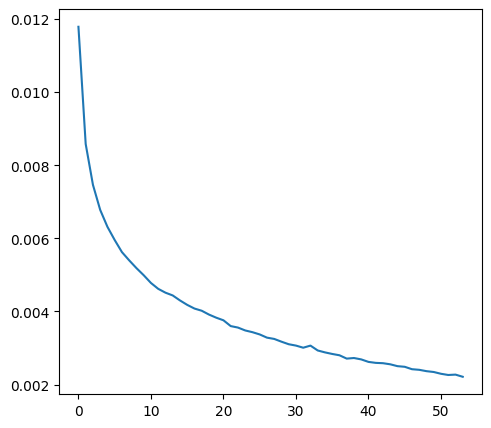

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 훈련 및 검증 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 훈련 및 검증 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [86]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=34fba8284b9c97504f731cf69a5614b6a2b1e2d0d2100f66487246ae01059f94
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet

import time

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 증강 및 정규화 설정
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet 정규화 사용
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# CIFAR10 데이터셋 로드
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 훈련/검증 데이터 분할
train_ratio = 0.8
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 데이터 로더 생성
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# EfficientNet-B0 모델 로드 및 수정
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10)  # CIFAR10 클래스 수: 10
model = model.to(device)

# 손실 함수, 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 정보 저장 리스트
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# 학습 함수 정의

def train(model, device, train_loader, optimizer, epoch, epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    startStr = f'Epoch {epoch+1:2d}/{epochs} \033[34m' + 'Train ' + '\033[0m'
    with tqdm(total=len(train_loader), desc=startStr) as pbar:
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
            pbar.update(1)
        train_loss = train_loss / train_total
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        str = f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.3f}%'
        pbar.set_postfix_str(str)

# 검증/테스트 함수 정의
def valid_or_test(mode, model, device, dataloader, epoch, epochs):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        if mode == 'valid':
            start_str = f'Epoch {epoch+1:2d}/{epochs} \033[34mValid\033[0m'
        elif mode == 'test':
            start_str = f'Epoch {epoch+1:2d}/{epochs} \033[34mTest\033[0m'

        with tqdm(total=len(dataloader), desc=start_str) as pbar:
            for data, target in dataloader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)

                loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
                pbar.update(1)

            loss = loss / total
            accuracy = 100 * correct / total
            if mode == 'valid':
                end_str = f'Valid Loss: {loss:.4f}, Valid Acc: {accuracy:.3f}%'
            elif mode == 'test':
                end_str = f'Test Loss: {loss:.4f}, Test Acc: {accuracy:.3f}%'
            pbar.set_postfix_str(end_str)

    if mode == 'valid':
        valid_losses.append(loss)
        valid_accuracies.append(accuracy)
        print('-' * 110)

# 학습 시작
epochs = 25
for epoch in range(epochs):
    train(model, device, train_loader, optimizer, epoch, epochs)
    #train(model, train_loader, criterion, optimizer, epoch, epochs)
    valid_or_test('valid', model, device, valid_loader, epoch, epochs)

# 테스트
valid_or_test('test', model, device, test_loader, epoch, epochs)

Files already downloaded and verified
Files already downloaded and verified
Loaded pretrained weights for efficientnet-b0


Epoch  1/25 Valid: 100%|██████████| 79/79 [00:04<00:00, 17.36it/s, Valid Loss: 0.0013, Valid Acc: 72.100%]


--------------------------------------------------------------------------------------------------------------


Epoch  2/25 Valid: 100%|██████████| 79/79 [00:05<00:00, 14.01it/s, Valid Loss: 0.0013, Valid Acc: 77.750%]


--------------------------------------------------------------------------------------------------------------


Epoch  3/25 Valid: 100%|██████████| 79/79 [00:04<00:00, 17.07it/s, Valid Loss: 0.0017, Valid Acc: 77.040%]


--------------------------------------------------------------------------------------------------------------


Epoch  4/25 Valid: 100%|██████████| 79/79 [00:05<00:00, 13.96it/s, Valid Loss: 0.0014, Valid Acc: 80.750%]


--------------------------------------------------------------------------------------------------------------


Epoch  5/25 Valid: 100%|██████████| 79/79 [00:04<00:00, 17.06it/s, Valid Loss: 0.0009, Valid Acc: 81.630%]


--------------------------------------------------------------------------------------------------------------


Epoch  6/25 Valid: 100%|██████████| 79/79 [00:04<00:00, 16.66it/s, Valid Loss: 0.0015, Valid Acc: 82.060%]


--------------------------------------------------------------------------------------------------------------


Epoch  7/25 Valid: 100%|██████████| 79/79 [00:05<00:00, 15.71it/s, Valid Loss: 0.0018, Valid Acc: 82.170%]


--------------------------------------------------------------------------------------------------------------


Epoch  8/25 Valid: 100%|██████████| 79/79 [00:04<00:00, 17.42it/s, Valid Loss: 0.0018, Valid Acc: 83.080%]


--------------------------------------------------------------------------------------------------------------


Epoch  9/25 Valid: 100%|██████████| 79/79 [00:05<00:00, 14.89it/s, Valid Loss: 0.0011, Valid Acc: 83.220%]


--------------------------------------------------------------------------------------------------------------


Epoch 10/25 Valid: 100%|██████████| 79/79 [00:04<00:00, 17.47it/s, Valid Loss: 0.0009, Valid Acc: 83.860%]


--------------------------------------------------------------------------------------------------------------


Epoch 11/25 Valid:  22%|██▏       | 17/79 [00:01<00:03, 17.41it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ed590506170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Epoch 11/25 Valid: 100%|██████████| 79/79 [00:05<00:00, 13.38it/s, Valid Loss: 0.0007, Valid Acc: 84.070%]


--------------------------------------------------------------------------------------------------------------


Epoch 12/25 Train :   5%|▍         | 15/313 [00:01<00:25, 11.90it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ed590506170>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ed590506170>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__

    self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", li

--------------------------------------------------------------------------------------------------------------


Epoch 13/25 Valid:  25%|██▌       | 20/79 [00:01<00:05, 11.15it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ed590506170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ed590506170>
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
:   

--------------------------------------------------------------------------------------------------------------


Epoch 14/25 Train :   5%|▌         | 16/313 [00:01<00:26, 11.16it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ed590506170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7ed590506170>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()
AssertionError
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
  

--------------------------------------------------------------------------------------------------------------


Epoch 15/25 Valid: 100%|██████████| 79/79 [00:05<00:00, 15.43it/s, Valid Loss: 0.0009, Valid Acc: 83.590%]


--------------------------------------------------------------------------------------------------------------


Epoch 16/25 Valid: 100%|██████████| 79/79 [00:04<00:00, 16.98it/s, Valid Loss: 0.0010, Valid Acc: 83.870%]


--------------------------------------------------------------------------------------------------------------


Epoch 17/25 Valid: 100%|██████████| 79/79 [00:04<00:00, 17.40it/s, Valid Loss: 0.0026, Valid Acc: 81.730%]


--------------------------------------------------------------------------------------------------------------


Epoch 18/25 Valid: 100%|██████████| 79/79 [00:05<00:00, 15.15it/s, Valid Loss: 0.0007, Valid Acc: 84.740%]


--------------------------------------------------------------------------------------------------------------


Epoch 19/25 Valid: 100%|██████████| 79/79 [00:04<00:00, 17.40it/s, Valid Loss: 0.0009, Valid Acc: 85.230%]


--------------------------------------------------------------------------------------------------------------


Epoch 20/25 Valid: 100%|██████████| 79/79 [00:05<00:00, 13.88it/s, Valid Loss: 0.0012, Valid Acc: 84.720%]


--------------------------------------------------------------------------------------------------------------


Epoch 21/25 Valid: 100%|██████████| 79/79 [00:04<00:00, 17.17it/s, Valid Loss: 0.0006, Valid Acc: 83.920%]


--------------------------------------------------------------------------------------------------------------


Epoch 22/25 Valid: 100%|██████████| 79/79 [00:05<00:00, 13.93it/s, Valid Loss: 0.0006, Valid Acc: 84.810%]


--------------------------------------------------------------------------------------------------------------


Epoch 23/25 Valid: 100%|██████████| 79/79 [00:04<00:00, 16.84it/s, Valid Loss: 0.0010, Valid Acc: 84.530%]


--------------------------------------------------------------------------------------------------------------


Epoch 24/25 Valid: 100%|██████████| 79/79 [00:04<00:00, 16.56it/s, Valid Loss: 0.0009, Valid Acc: 85.140%]


--------------------------------------------------------------------------------------------------------------


Epoch 25/25 Valid: 100%|██████████| 79/79 [00:06<00:00, 12.60it/s, Valid Loss: 0.0019, Valid Acc: 84.700%]


--------------------------------------------------------------------------------------------------------------


Epoch 25/25 Test: 100%|██████████| 79/79 [00:03<00:00, 21.73it/s, Test Loss: 0.0014, Test Acc: 84.810%]
